In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special

from matplotlib import cm
from mpmath import mp
from tqdm import tqdm

# Using Weierstraß Theorem to construct a DNN approximation of $\cos(x)$ on $K = \left[\frac{5}{4}, \frac{7}{4}\right]$
We follow the construction in the proof of Lemma 2, to construct a DNN which approximates $\cos(x)$ on $K = \left[\frac{5}{4}, \frac{7}{4}\right]$.

## Approximating $\cos(x)$ on $K$ with polynomials (using Weierstraß Theorem)
To use Weierstraß Theorem, we follow the construction in [OC2], so we first precompose $f(x)=\cos(x)$ with an affine function $A$, to get a new function which has the same values on $[0,1]$ as $\cos(x)$ on $\left[\frac{5}{4}, \frac{7}{4}\right]$.

In [2]:
# Define f, affine transformation and its inverse.
f = lambda x: np.sin(x)
Af = lambda x: x/2 + 1.25
Ainv = lambda x: (x-1.25)*2

# Define transposed f.
f_trans = lambda x: f(Af(x))

We use Weierstraß' Theorem to approximate $f_{trans}$ as
\begin{align}
Q_{N}(x)=\sum_{n=0}^{N} f\left(\frac{n}{N}\right)\left(\begin{array}{c}
N \\
n
\end{array}\right) x^{n}(1-x)^{N-n},
\end{align}

where

\begin{align*}
\left(\begin{array}{c}
N \\
n
\end{array}\right) = \frac{N!}{n!(N-n)!}.
\end{align*}

In [3]:
# Calculating Q_N
Q_N = lambda x, N: sum([f_trans(n/N) * scipy.special.binom(N, n)*x**n*(1-x)**(N-n) for n in range(N+1)])

Error for N=1:  0.03100046683211022
Error for N=2:  0.015502072751663709
Error for N=3:  0.010347102530368302
Error for N=4:  0.007766652985560785
Error for N=5:  0.0062167905504776355


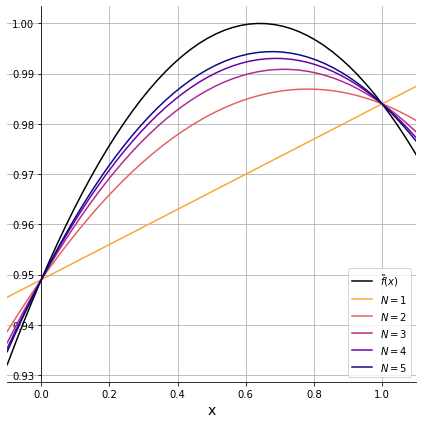

In [4]:
# Plotting Q_N for different values of N together with f_ans.

x = np.linspace(-0.1,1.1,num=50)
x_subset = np.linspace(0,1,num=50)

N_range = 6

# Initialize colors.
cm_subset = np.linspace(1,0,N_range)
colors = [cm.plasma(x) for x in cm_subset]

# Define font settings.
font = {'size'   : 14}

# Initialize plot.
fig, ax = plt.subplots(figsize=(6,6))

fx = f_trans(x)
fx_err = f_trans(x_subset)
ax.plot(x, fx, color='k', label=r'$\tilde{f}(x)$')

for N in range(1,N_range):
    fx_approx = Q_N(x,N)
    fx_approx_err = Q_N(x_subset,N)
    ax.plot(x, fx_approx, color=colors[N], label=r'$N=$'+str(N))
    print('Error for N='+str(N)+': ', np.max(np.abs(fx_err - fx_approx_err)))

ax.set_xlabel('x', **font)
#ax.set_ylabel('f(x)', **font)
    
ax.spines['left'].set_position('zero')   
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

plt.xlim(-0.1,1.1)
plt.grid()

plt.legend(loc=4)
plt.tight_layout()

plt.savefig('Q_N.pdf')
plt.show()

Say we wanted to approximate $f$ to within an error of $\varepsilon = 0.03$. Then $N=2$ would be sufficient. 
For this value we get the polynomial

\begin{align}
    Q_2(x) = x^2 \left(f_{trans}(0) - 2f_{trans}\left(\frac{1}{2}\right) + f_{trans}(1)\right) + 2x \left(-f_{trans}(0) + f_{trans}\left(\frac{1}{2}\right)\right) + f_{trans}(0).
\end{align}

For convenience we define
\begin{align}
    A &= \left(f_{trans}(0) - 2f_{trans}\left(\frac{1}{2}\right) + f_{trans}(1)\right), \\
    B &= 2\left(-f_{trans}(0) + f_{trans}\left(\frac{1}{2}\right)\right),
\end{align}

such that $Q_2(x) = Ax^2 + Bx + f_{trans}(0)$.

To transpose it back we precompose it with $A^{-1}$ to get $P_2(x) = Q_2(A^{-1}(x))$ yielding

\begin{align}
    P_2(x) &= (2x-2.5)^2 A + (2x-2.5) B + f_{trans}(0), \\
    &= 4A x^2 + (2B-10A)x + \frac{25}{4}A - \frac{5}{2}B + f_{trans}(0).
\end{align}

In [5]:
# Defining P_2
A = f_trans(0) - 2* f_trans(1/2) + f_trans(1)
B = 2*(f_trans(1/2)- f_trans(0))

P2 = lambda x: 4*A*x**2 + (2*B-10*A)*x + 25/4*A - 5/2*B + f_trans(0)


# Test if error of the transposed function is the same as on the transposed domain.
x_trans = np.linspace(5/4,7/4,num=50)

print(np.max(np.abs(P2(x_trans)-np.sin(x_trans))))

0.01550207275166382


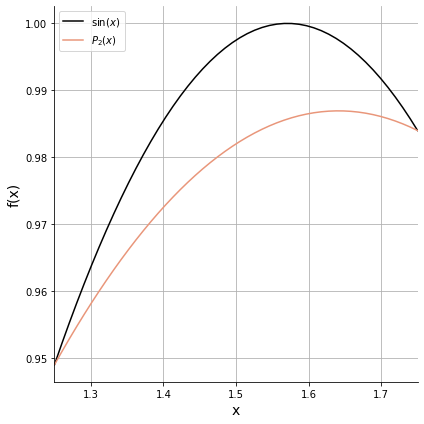

In [6]:
# Visual confirmation of P2 approximating sin(x) on [5/4, 7/4].
K = np.linspace(5/4, 7/4, num=50)

fig, ax = plt.subplots(figsize=(6,6))

ax.plot(K, f(K), color='k', label=r'$\sin(x)$')
ax.plot(K, P2(K), color='darksalmon', label=r'$P_2(x)$')

ax.set_xlabel('x', **font)
ax.set_ylabel('f(x)', **font)
    
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

plt.xlim(5/4,7/4)
plt.grid()

plt.legend()
plt.tight_layout()

plt.show()

## Converting $P_2$ to a DNN in $\mathcal{NN}^{\rho}_{1,1,3}$

We follow the construction in the proof of Lemma 2, to convert $P_2$ into a DNN $g\in\mathcal{NN}^{\rho}_{1,1,3}$.

$P_2$ is composed of three monomials (one of them being constant). They are
\begin{align}
    \gamma_1 &= 4Ax^2 \\
    \gamma_2 &= (2B-10A)x \\
    \gamma_3 &= 25/4A-5/2B+f_{trans}(0).
\end{align}

Following Corollary ??? we rewrite $P_2$
\begin{align}
    P_2(x) = \gamma_1 \left(1+\frac{\gamma_2}{\gamma_1}\left(1+\frac{\gamma_3}{\gamma_2}\right)\right).
\end{align}

Since $\gamma_1$ is a constant, then we will just calculate $P_2$ as

\begin{align}
    P_2(x) = \gamma_1 + \gamma_2\left(1+\frac{\gamma_3}{\gamma_2}\right).
\end{align}

We define the two necessary neural networks, namely $\mu$ and $r$.

In [7]:
# ____Defining r and mu, as 'reci' and 'mult' respectively____.

## Defining utilitary functions.

# Activation function and I_h.
rho = lambda x: x**2
d_rho = lambda x: 2*x

phi_h = lambda x, alpha: h*x + alpha
psi_h = lambda x, h, alpha: (x - rho(alpha))/(h*d_rho(alpha))

I_h = lambda x, h, alpha: psi_h(rho(phi_h(x, alpha)), h, alpha)

# Define functions.
eta1 = lambda x, h, alpha: I_h(x, h, alpha)
zeta1 = lambda x, y, s: rho(x+s*y+1)

eta2 = lambda x, h, alpha: rho(eta1(x, h, alpha))
zeta2 = lambda x, y, s, h, alpha: I_h(zeta1(x,y,s) - 2*eta1(x, h, alpha) - 1, h, alpha)

eta3 = lambda x, h, alpha: I_h(eta2(x,h, alpha), h, alpha)
zeta3 = lambda x, y, s, h, alpha: I_h((zeta2(x, y, s, h, alpha) - eta2(x, h, alpha))/(2*s), h, alpha)



def reci(x, h, s, alpha, n):
    # Initialize first layer.
    eta = (1-x)**2
    zeta = 2-x
    
    # Compose with kappa_{h,s} n times.
    for i in range(n):
        eta_new = eta3(eta, h, alpha)
        zeta_new = zeta3(eta, zeta, s, h, alpha)
    
        eta = eta_new
        zeta = zeta_new
        
    return(zeta)

def mult(x, y):
    eta = rho(x+y)
    zeta = rho(x-y)
    
    return(1/4*eta - 1/4*zeta)

We can now define $g$.

Notice that some of the layers are combined, for instance $\gamma_3$ and $1/x$ are both calculated in the first layer, and that the numbering of the layers is not precise, since both $\texttt{reci}$ and $\texttt{mult}$ require more than one layer.

In [8]:
def g(x, s, h, alpha, n, consts):
    """
    we use y_i_j to denote the output of the j-th neuron in the i-th layer.
    """
    
    # ____Defining constants____.
    A = consts[0]
    B = consts[1]
    C = consts[2]
    
    
    # ____L A Y E R   1____
    # Approximating gamma_3 & Calculating 1/x.
    
    y_1_1 = reci(x, h, s, alpha, n)           # ≈ 1/x.
    y_1_2 = I_h(25/4*A - 5/2*B + C, h, alpha) # ≈ gamma_3.
    
    
    # ____L A Y E R   2____
    # Approximating gamma_3/gamma_2 & 1/(1/x).    

    y_2_1 = reci(y_1_1, h, s, alpha, n)       # ≈ 1/(1/x) = x.
    y_2_2 = mult(1/(2*B-10*A)*y_1_1, y_1_2)   # ≈ gamma_3/gamma_2.
    
    
    # ____L A Y E R   3____
    # Approximating gamma2(1+gamma_3/gamma_2).    

    y_3_1 = mult(1+y_2_2, (2*B-10*A)*y_2_1)   # ≈ gamma_2 (1 + gamma_3/gamma_2)
    
    
    # ____L A Y E R   4 - O U T P U T L A Y_E_R____
    # Returning gamma_1 + gamma_2(1+gamma_3/gamma_2).    
    
    return 25/4*A - 5/2*B + C + y_3_1

Approximation error:  1.403377309202445


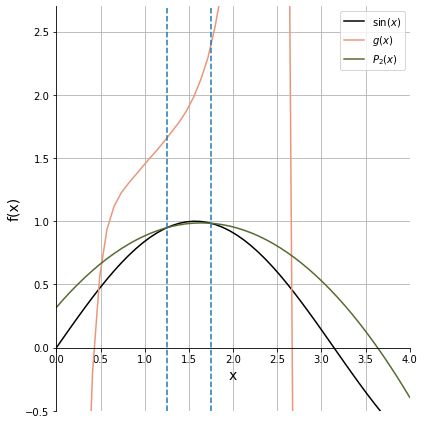

In [9]:
# Define inputs.
x = np.linspace(0, 4, num=50)
K = np.linspace(5/4, 7/4, num=50)
s = 1e-3   # s' from 1/(1/x) simulation.
h = 1e-10  # h' from 1/(1/x) simulation.
alpha = 1
n = 1
consts = [A, B, f_trans(0)]

# Calculate g(x) on [5/4, 7/4].
gx = g(x, s, h, alpha, n, consts)


# Calculate approximation error on [5/4, 7/4].
gK = g(K, s, h, alpha, n, consts)
print("Approximation error: ", np.max(np.abs(gK - f(K))))


# Plot approximation.
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(x, f(x), color='k', label=r'$\sin(x)$')
ax.plot(x, gx, color='darksalmon', label=r'$g(x)$')
ax.plot(x, P2(x), color='darkolivegreen', label=r'$P_2(x)$')

# Vertical lines to indicate K.
plt.axvline(x=5/4, ls='--')
plt.axvline(x=7/4, ls='--')

ax.set_xlabel('x', **font)
ax.set_ylabel('f(x)', **font)
    
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

plt.xlim(0,4)
plt.ylim(-0.5,2.7)
plt.grid()

plt.legend()
plt.tight_layout()

plt.savefig('p_g_sin.pdf')

plt.show()

### Optimizing over $s$, $h$, $n$, and $\alpha$
To see how well the model performs, we abandon the theory and try to optimize our $g$ network.

In [10]:
err = np.zeros((10,10,10,10))

s_set = np.logspace(-1, -10, num=10)
h_set = np.logspace(-1, -10, num=10)
alpha_set = np.logspace(0, 9, num=10)
n_set = np.arange(0,10)

for i1, s in enumerate(s_set):
    for i2, h in enumerate(h_set):
        for i3, alpha in enumerate(alpha_set):
            for i4, n in enumerate(n_set):
                gK = g(K, s, h, alpha, n, consts)
                err[i1, i2, i3, i4] = np.max(np.abs(gK - f(K)))

<ipython-input-7-4ade67d52677>:6: RuntimeWarning: overflow encountered in square
  rho = lambda x: x**2
<ipython-input-7-4ade67d52677>:45: RuntimeWarning: invalid value encountered in subtract
  return(1/4*eta - 1/4*zeta)
<ipython-input-7-4ade67d52677>:19: RuntimeWarning: invalid value encountered in subtract
  zeta2 = lambda x, y, s, h, alpha: I_h(zeta1(x,y,s) - 2*eta1(x, h, alpha) - 1, h, alpha)
<ipython-input-7-4ade67d52677>:22: RuntimeWarning: invalid value encountered in subtract
  zeta3 = lambda x, y, s, h, alpha: I_h((zeta2(x, y, s, h, alpha) - eta2(x, h, alpha))/(2*s), h, alpha)
<ipython-input-7-4ade67d52677>:22: RuntimeWarning: overflow encountered in true_divide
  zeta3 = lambda x, y, s, h, alpha: I_h((zeta2(x, y, s, h, alpha) - eta2(x, h, alpha))/(2*s), h, alpha)
<ipython-input-7-4ade67d52677>:10: RuntimeWarning: overflow encountered in true_divide
  psi_h = lambda x, h, alpha: (x - rho(alpha))/(h*d_rho(alpha))
<ipython-input-7-4ade67d52677>:28: RuntimeWarning: overflow enco

In [11]:
# Remove nan values.
err[np.isnan(err)] = np.inf

# Find optimal values.
opt_ind = (err == err.min()).nonzero()

print("Minimal error: ", err.min())

opt_ind

Minimal error:  0.6811785209805906


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

In [12]:
print("Number of optimal combinations: ", len(opt_ind[0]))

Number of optimal combinations:  700


We observe that 134 out of $10^4$ combinations of parameters result in the same minimal error, namly err$=0.6811$. We will chose the simplest model in the sense that the parameters requires the lowest amount of memory to represent, i.e. parameters closest to $1$, so we can find the simplest model by summing the values of the different indices, since the parameter sets are sorted such that higher indices equals more values further away from $1$.

We extract the parameters and plot $g$. We only plot $g$ on $K$, since $\texttt{reci}$ is not (necessarily) defined outside this interval.

In [13]:
sum(opt_ind)

array([20, 17, 18, 19, 20, 21, 22, 23, 24, 25, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 18, 19, 20, 21, 22, 23, 24, 25, 26, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 18, 19, 20, 21, 22, 23, 24, 25, 26, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 19, 18, 19, 20, 21, 22, 23, 24, 25, 26, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 19, 20, 21, 22, 23, 24, 25, 26, 27, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 19, 20, 21, 22, 23, 24, 25, 26, 27, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 19, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 19, 20, 21, 22, 23, 24, 25, 26, 27, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 19, 20, 21, 22, 23, 24, 25, 26, 27, 20, 21, 22, 23, 24, 25,
       26, 27, 28, 21, 22, 23, 24, 25, 26, 27, 28, 29, 19, 20, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 20, 21, 22, 23, 24, 25, 26, 27, 28, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 20, 21, 22, 23, 24, 25, 26, 27, 28, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 22, 23, 24, 25, 26, 27, 28, 29, 30,
       20, 21, 22, 23, 24

In [14]:
## We simply have to take the first value of each parameter set:
# Extract optimal indices.
s_ind = opt_ind[0][0]
h_ind = opt_ind[1][0]
alpha_ind = opt_ind[2][0]
n_ind = opt_ind[3][0]

# Optimal parameters.
s_opt = s_set[s_ind]
h_opt = h_set[h_ind]
alpha_opt = alpha_set[alpha_ind]
n_opt = n_set[n_ind]

Approximation error:  0.6811785209805906


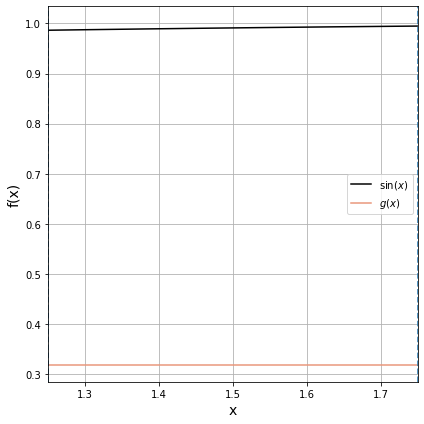

In [15]:
# Plot g for optimal parameters.

# Define inputs.
K = np.linspace(5/4, 7/4, num=50)
s = s_opt
h = h_opt
alpha = int(alpha_opt)
n = int(n_opt)
consts = [A, B, f_trans(0)]

# Calculate approximation error on [5/4, 7/4].
gK = g(K, s, h, alpha, n, consts)
print("Approximation error: ", np.max(np.abs(gK - f(K))))


# Plot approximation.
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(x, f(K), color='k', label=r'$\sin(x)$')
ax.plot(x, gK, color='darksalmon', label=r'$g(x)$')

# Vertical lines to indicate K.
plt.axvline(x=5/4, ls='--')
plt.axvline(x=7/4, ls='--')

ax.set_xlabel('x', **font)
ax.set_ylabel('f(x)', **font)
    
#ax.spines['left'].set_position('zero')
#ax.spines['bottom'].set_position('zero')
#ax.spines['right'].set_color('none')
#ax.spines['top'].set_color('none')

plt.xlim(5/4,7/4)
#plt.ylim(-1,2.7)
plt.grid()

plt.legend()
plt.tight_layout()

plt.show()

The approximation does not look good! It appears that the DNN is just a constant:

In [16]:
gK

array([0.31881149, 0.31881149, 0.31881149, 0.31881149, 0.31881149,
       0.31881149, 0.31881149, 0.31881149, 0.31881149, 0.31881149,
       0.31881149, 0.31881149, 0.31881149, 0.31881149, 0.31881149,
       0.31881149, 0.31881149, 0.31881149, 0.31881149, 0.31881149,
       0.31881149, 0.31881149, 0.31881149, 0.31881149, 0.31881149,
       0.31881149, 0.31881149, 0.31881149, 0.31881149, 0.31881149,
       0.31881149, 0.31881149, 0.31881149, 0.31881149, 0.31881149,
       0.31881149, 0.31881149, 0.31881149, 0.31881149, 0.31881149,
       0.31881149, 0.31881149, 0.31881149, 0.31881149, 0.31881149,
       0.31881149, 0.31881149, 0.31881149, 0.31881149, 0.31881149])

We try to do the gridsearch once again, but using an 'mpfier' this time.

**WARNING!** The next can run for a long time, depending on the decimal precision and the size of the grid.

In [17]:
%%time

# Define mpfier
mpfier = mp.mpf(1)
mp.dps = 50 # Define the decimal precision.

err = np.zeros((5, 5, 5, 5))

K = np.linspace(5/4, 7/4, num=50)
mpK = mpfier * K

s_set = np.logspace(-2, -10, num=5)
h_set = np.logspace(-2, -10, num=5)
alpha_set = np.arange(1,6)
n_set = np.arange(1,6)

for i1, s in tqdm(enumerate(s_set)):
    for i2, h in enumerate(h_set):
        for i3, alpha in enumerate(alpha_set):
            for i4, n in enumerate(n_set):
                gK = g(mpK, s, h, alpha, n, consts)
                err[i1, i2, i3, i4] = np.max(np.abs(gK - f(K)))

5it [00:48,  9.76s/it]

CPU times: user 48.3 s, sys: 199 ms, total: 48.5 s
Wall time: 48.9 s


In [18]:
# Remove nan values.
err[np.isnan(err)] = np.inf

# Find optimal values.
opt_ind = (err == err.min()).nonzero()

print("Minimal error: ", err.min())

opt_ind

Minimal error:  0.6811785209805906


(array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2]),
 array([0, 1, 1, 1, 2, 3, 3, 3, 3, 4, 4, 4, 4, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 0, 0, 0, 0, 1, 1, 1, 1, 2,
        2, 2, 2, 3, 3, 3, 4, 4, 4, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 

We see no improvements, when increasing the decimal precision.